In [150]:
import math
from pickletools import optimize
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



msft = yf.Ticker("MSFT")
df = msft.history(start ='2000-01-01' , end = '2019-01-01')
df.to_csv('../CSV/msft.csv')

df = pd.read_csv('../CSV/msft.csv')

#data set for training
data = df.filter(['Close'])
dataset = data.values

#scales data into 1-0
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(dataset)

#training sets 
train_size = int(df.shape[0] * 0.8)
train_set = scaler_data[0: train_size, :]

x_train = []
y_train = []

for i in range(60, train_size):
    x_train.append(train_set[i-60: i, 0])
    y_train.append(train_set[i,0])



x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size = 1, epochs = 1)





3763/3763 [==============================] - 124s 32ms/step - loss: 1.5640e-04


1.8268255169920344


/var/folders/w_/bcbslvsd4cz_kwppplndj7gc0000gn/T/ipykernel_1070/991941257.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


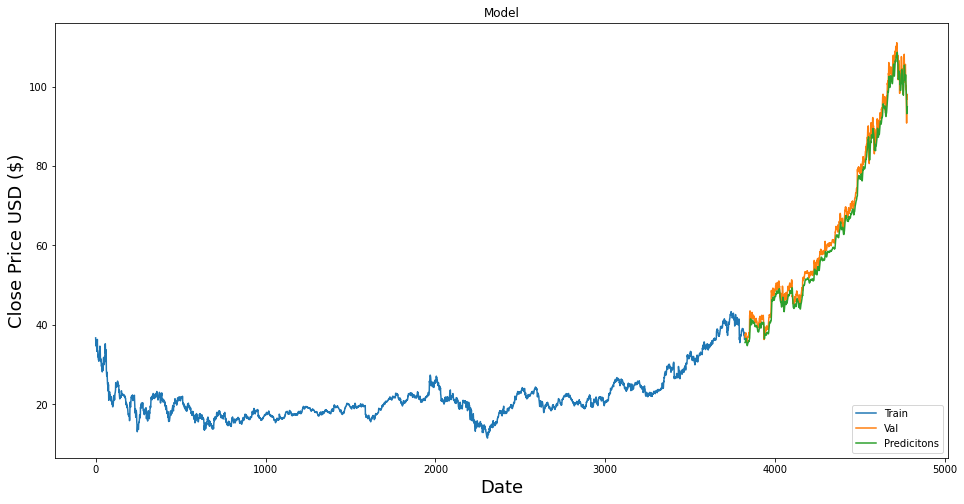

<Figure size 432x288 with 0 Axes>

In [151]:
test_data = scaler_data[train_size -60:, :]

x_test = []
y_test = dataset[train_size:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean( predictions - y_test)**2)

print(rmse)

train = data[:train_size]
valid = data[train_size:]
valid['Predictions'] = predictions

#Visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predicitons'], loc = 'lower right')
plt.show()
plt.savefig("../plots/visualize.png")



In [152]:


apple = yf.Ticker("AAPL")
df = apple.history(start ='2015-01-01', end = '2016-01-01')
new_df = df.filter(['Close'])
data = new_df[-60:].values

data_scaled = scaler.transform(data)
apple_60_predictions = []

for i in range(60):
    x_test = []
    x_test.append(data_scaled)
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    pred_price = model.predict(x_test)
    data_scaled= np.concatenate((data_scaled[1:], [[pred_price[0][0]]]))
    pred_price = scaler.inverse_transform(pred_price)
    apple_60_predictions.append(pred_price[0][0])

df = apple.history(start ='2016-01-01')
print("Predictions" , "Actual")
for i in range(60):
    print(apple_60_predictions[i],"    ", df['Close'][i])





Predictions Actual
23.969952      24.18504524230957
23.74617      23.578981399536133
23.509314      23.117551803588867
23.27297      22.14188575744629
23.042694      22.258962631225586
22.820894      22.6193904876709
22.608454      22.947668075561523
22.405392      22.357677459716797
22.211216      22.84665870666504
22.025171      22.29798698425293
21.846388      22.190093994140625
21.673998      22.219938278198242
21.507204      22.107450485229492
21.345331      23.2828369140625
21.187813      22.82829475402832
21.034225      22.954559326171875
20.884245      21.446290969848633
20.73765      21.600101470947266
20.594288      22.346195220947266
20.454065      22.137287139892578
20.316927      21.68963050842285
20.18284      22.118925094604492
20.051779      22.296649932861328
19.923735      21.701147079467773
19.798681      21.929658889770508
19.6766      21.9250431060791
19.557459      21.758853912353516
19.441221      21.627288818359375
19.32784      21.694231033325195
19.217272     

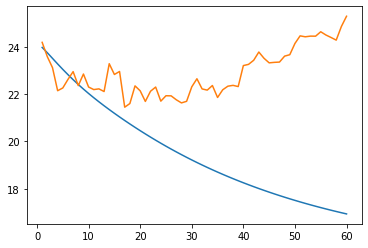

In [153]:
index = []
for i in range(60):
    index.append(i+1)

plt.plot(index, apple_60_predictions , 
        index , df['Close'][:60] )
plt.show()
